## Importing Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

## Data Preparation
* As we are working with TESS dataset, so we will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [3]:
paths = []
labels = []

In [4]:
for dirname, _, filenames in os.walk('./TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        if label == 'ps':
            label='surprise'
        labels.append(label.lower())

print("TESS Dataset is Loaded")


TESS Dataset is Loaded


In [5]:
paths[:5]

['./TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 './TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 './TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 './TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 './TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']

In [6]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [7]:
# create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,./TESS Toronto emotional speech set data\OAF_a...,angry
1,./TESS Toronto emotional speech set data\OAF_a...,angry
2,./TESS Toronto emotional speech set data\OAF_a...,angry
3,./TESS Toronto emotional speech set data\OAF_a...,angry
4,./TESS Toronto emotional speech set data\OAF_a...,angry


In [8]:
df.shape

(2800, 2)

In [9]:
df['label'].value_counts()

label
angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: count, dtype: int64

In [10]:
df.to_csv("data_path.csv",index=False)

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

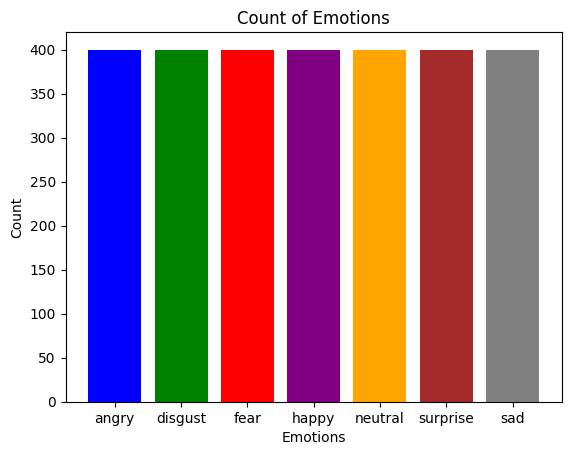

In [11]:
# Define the colors for each emotion label
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'gray', 'black']

# Count the number of samples for each emotion label
label_counts = df['label'].value_counts()

# Create a bar chart with different colors for each label
plt.bar(label_counts.index, label_counts.values, color=colors)

# Set the title and axis labels
plt.title('Count of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Count')

# Display the plot
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [12]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
     x = librosa.stft(data)
     xdb = librosa.amplitude_to_db(abs(x))
     plt.figure(figsize=(11,4))
     plt.title(emotion, size=20)
     librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
     plt.colorbar()

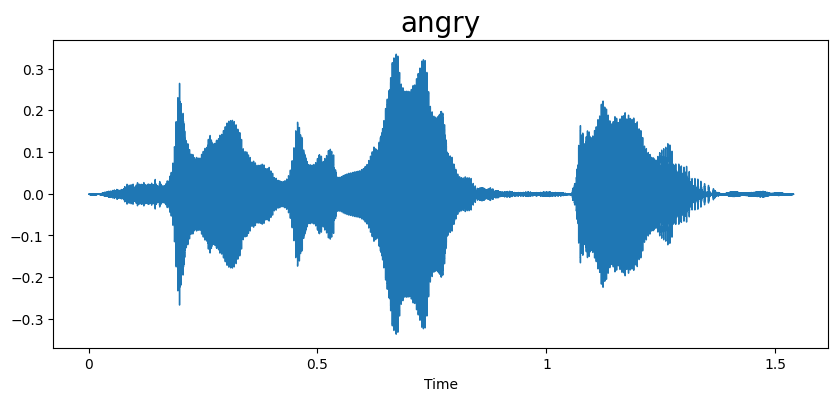

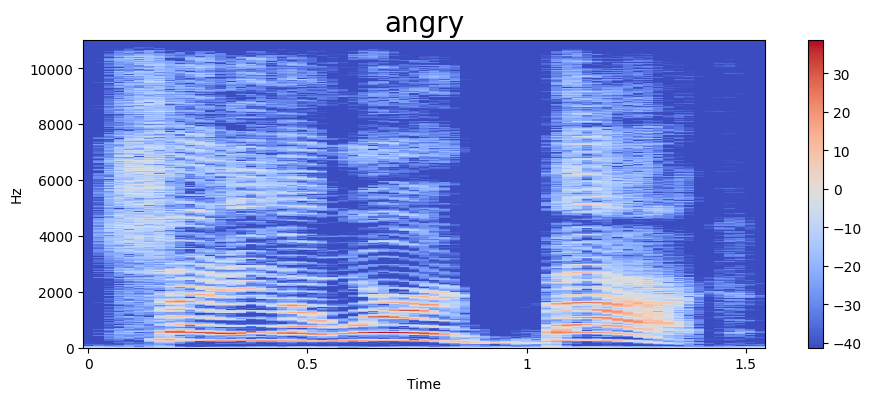

In [13]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

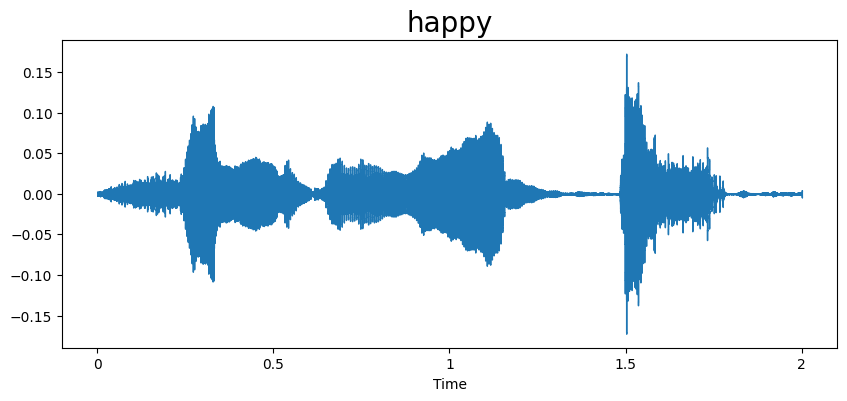

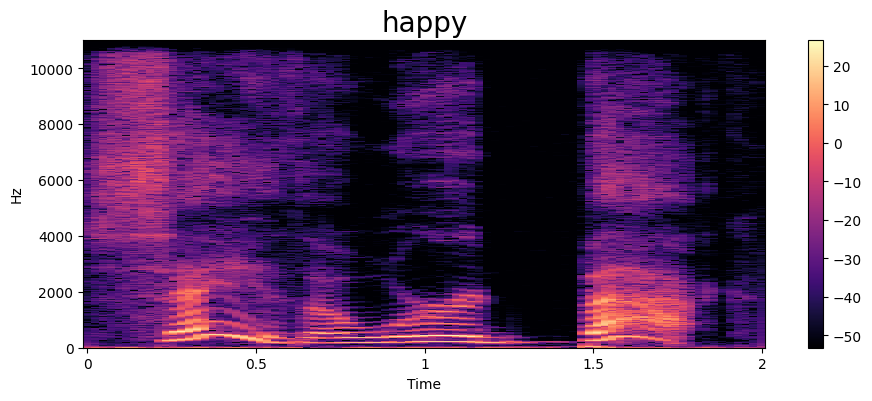

In [14]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

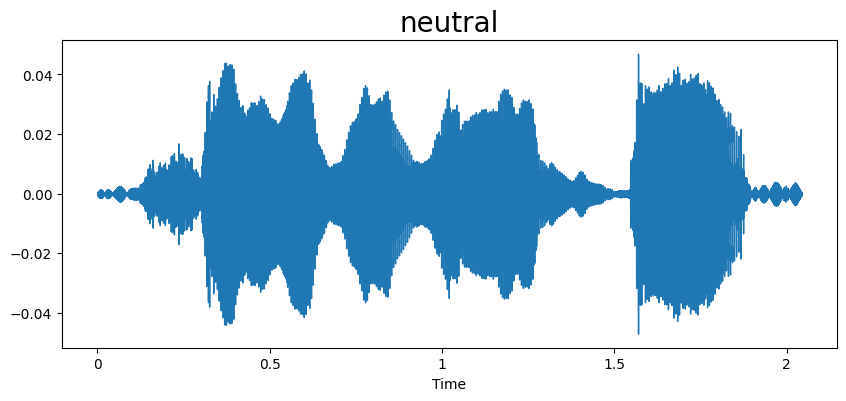

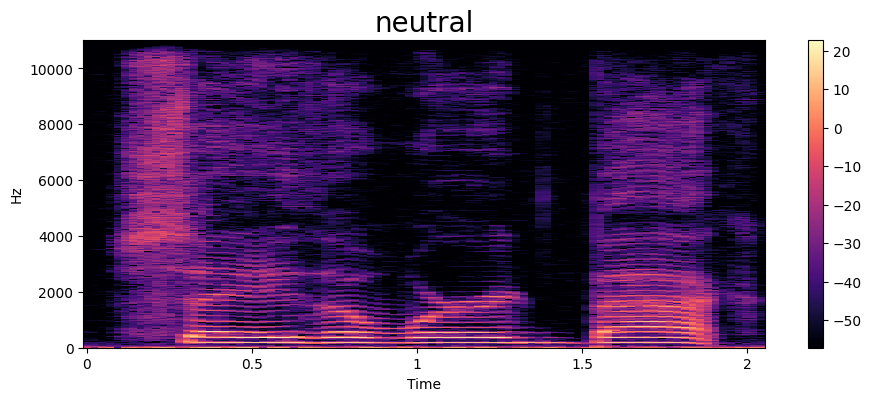

In [15]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

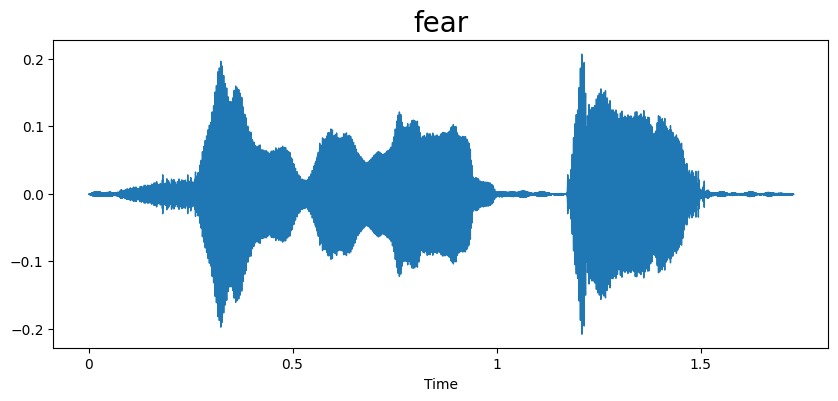

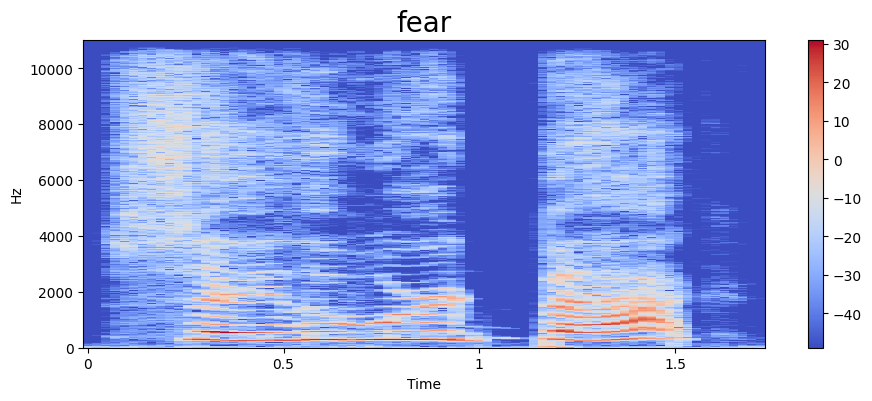

In [16]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

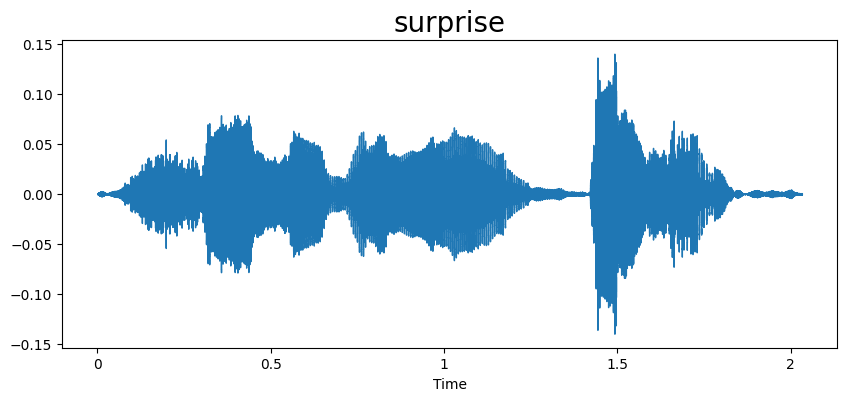

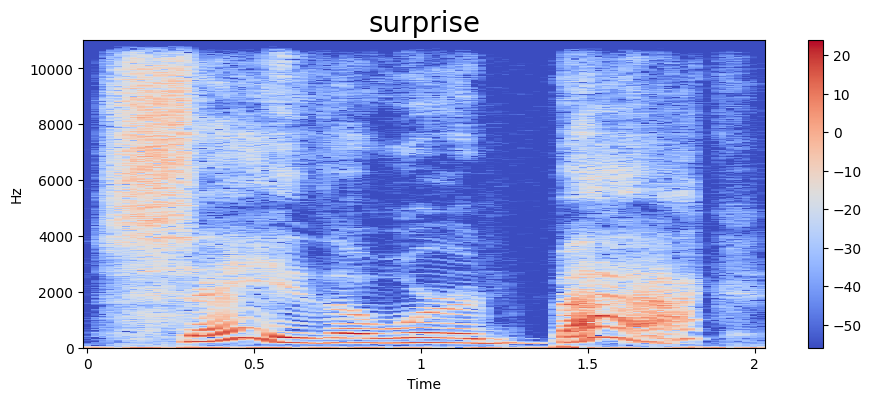

In [17]:
emotion = 'surprise'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

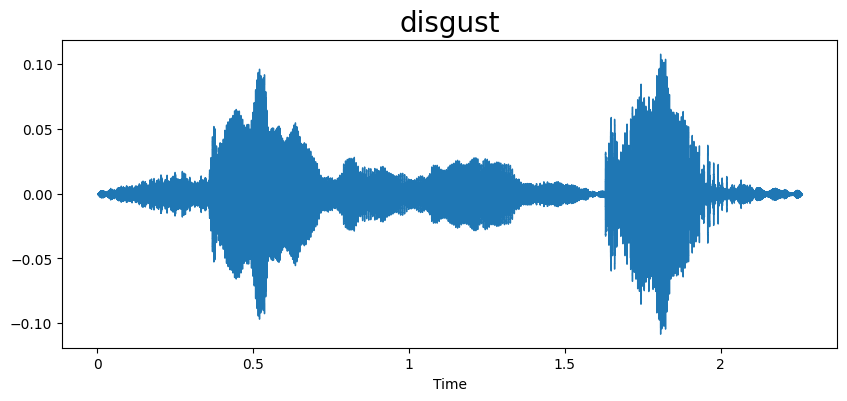

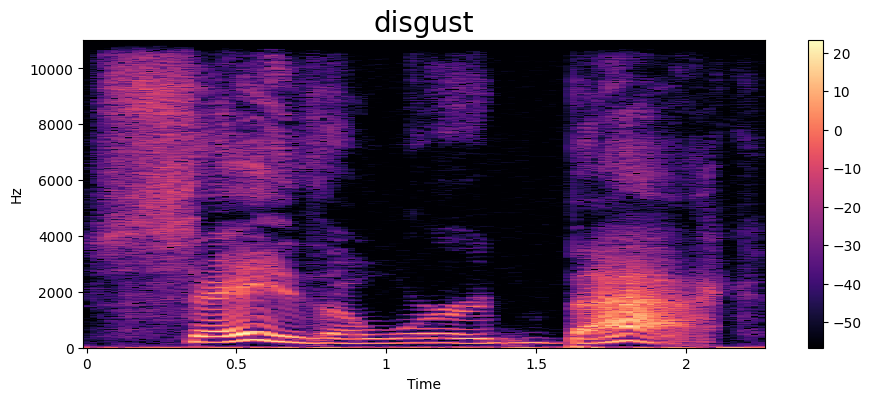

In [18]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

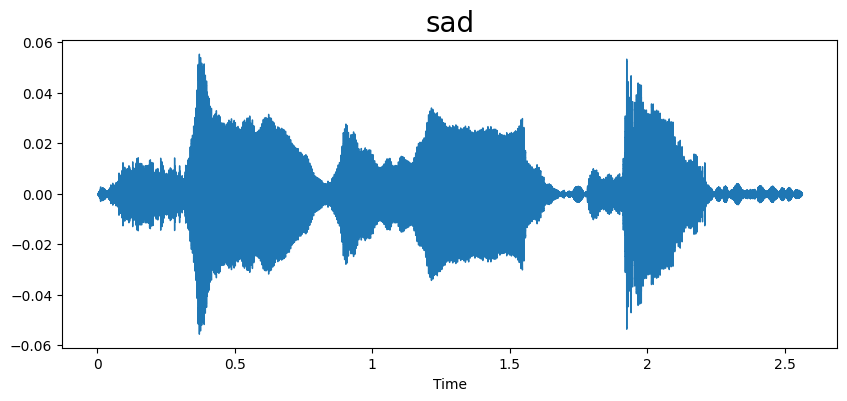

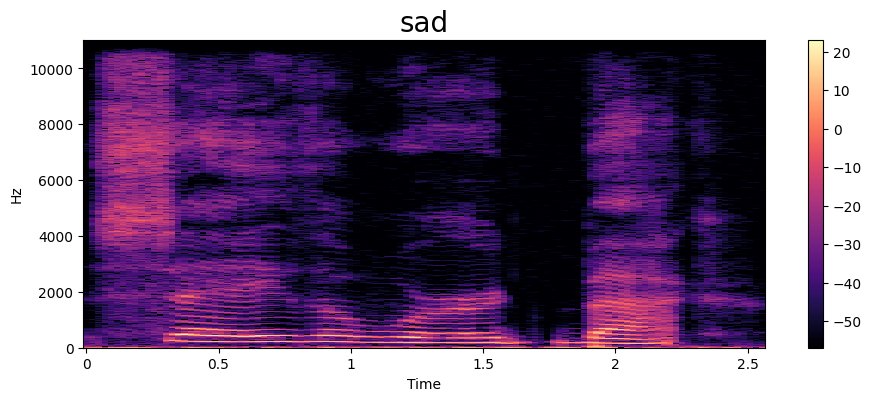

In [19]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
In this project we use MFCCs (Mel Frequency Cepstral Coefficients) form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [20]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [21]:
extract_mfcc(df['speech'][0])

array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
       -2.11275506e+00,  1.00753632e+01, -2.03667068e+01, -6.09244919e+00,
       -7.21228361e+00, -5.57365894e-01, -1.83255327e+00,  2.02101514e-01,
        7.27550924e-01,  1.31773770e+00,  2.88633752e+00,  2.85579133e+00,
       -4.71292162e+00, -4.43651056e+00, -1.62115920e+00, -1.02398405e+01,
       -7.55126286e+00, -1.79688025e+00, -7.03765202e+00,  9.43658447e+00,
        8.35585499e+00,  2.17123604e+01,  1.92169895e+01,  2.03489265e+01,
        1.34133663e+01,  8.33917141e+00,  3.94722492e-01,  5.11131430e+00,
        9.56873894e+00,  5.45486784e+00,  2.50996351e+00, -1.82390726e+00,
        4.86896276e+00,  9.31392288e+00,  2.08915019e+00, -1.90649128e+00],
      dtype=float32)

In [22]:
X_mfcc = []
for x in tqdm(df['speech'], ncols=100):
    X_mfcc.append(extract_mfcc(x))


100%|███████████████████████████████████████████████████████████| 2800/2800 [00:41<00:00, 66.67it/s]


In [23]:
X_mfcc

[array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
        -2.11275506e+00,  1.00753632e+01, -2.03667068e+01, -6.09244919e+00,
        -7.21228361e+00, -5.57365894e-01, -1.83255327e+00,  2.02101514e-01,
         7.27550924e-01,  1.31773770e+00,  2.88633752e+00,  2.85579133e+00,
        -4.71292162e+00, -4.43651056e+00, -1.62115920e+00, -1.02398405e+01,
        -7.55126286e+00, -1.79688025e+00, -7.03765202e+00,  9.43658447e+00,
         8.35585499e+00,  2.17123604e+01,  1.92169895e+01,  2.03489265e+01,
         1.34133663e+01,  8.33917141e+00,  3.94722492e-01,  5.11131430e+00,
         9.56873894e+00,  5.45486784e+00,  2.50996351e+00, -1.82390726e+00,
         4.86896276e+00,  9.31392288e+00,  2.08915019e+00, -1.90649128e+00],
       dtype=float32),
 array([-4.6573267e+02,  9.8773727e+01,  6.5600872e-01, -3.2745441e+01,
        -1.1261922e+01,  1.2688793e+01, -1.1675358e+00, -3.4115872e+00,
        -1.0514169e+01,  4.3031459e+00, -1.2010704e+01,  1.0480854e+01,


In [24]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape
X

array([[-396.9862   ,   77.44054  ,  -19.59279  , ...,    9.313923 ,
           2.0891502,   -1.9064913],
       [-465.73267  ,   98.77373  ,    0.6560087, ...,    8.680707 ,
           4.173659 ,    3.258969 ],
       [-429.79196  ,   46.124    ,    1.5550478, ...,    8.633682 ,
          -2.4228284,   -2.3461313],
       ...,
       [-378.50494  ,   80.91062  ,   35.300533 , ...,    6.463878 ,
           4.545148 ,    7.043935 ],
       [-434.8618   ,   89.906364 ,   28.373262 , ...,   10.526768 ,
          11.808919 ,   10.119673 ],
       [-421.8341   ,   70.69788  ,   32.476387 , ...,    5.080212 ,
           5.1315765,    6.3598347]], dtype=float32)

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [25]:
# input split
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [26]:
encoder = OneHotEncoder()
y = encoder.fit_transform(df[['label']])

In [27]:
y = y.toarray()

In [28]:
y.shape

(2800, 7)

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.35)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1820, 40, 1), (1820, 7), (980, 40, 1), (980, 7))

## Modelling

In [30]:
# Create LSTM Model

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [31]:
# Train the Model

history = model.fit(x_train, y_train, batch_size=1024, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
2/2 [==============================] - 6s 2s/step - loss: 1.8951 - accuracy: 0.2033 - val_loss: 1.7578 - val_accuracy: 0.3847
Epoch 2/50
2/2 [==============================] - 3s 1s/step - loss: 1.7638 - accuracy: 0.3154 - val_loss: 1.6201 - val_accuracy: 0.4000
Epoch 3/50
2/2 [==============================] - 3s 1s/step - loss: 1.6418 - accuracy: 0.3676 - val_loss: 1.4516 - val_accuracy: 0.4949
Epoch 4/50
2/2 [==============================] - 2s 1s/step - loss: 1.4832 - accuracy: 0.4456 - val_loss: 1.2529 - val_accuracy: 0.5316
Epoch 5/50
2/2 [==============================] - 2s 1s/step - loss: 1.3030 - accuracy: 0.5060 - val_loss: 1.0387 - val_accuracy: 0.6010
Epoch 6/50
2/2 [==============================] - 2s 1s/step - loss: 1.1185 - accuracy: 0.5560 - val_loss: 0.8944 - val_accuracy: 0.6255
Epoch 7/50
2/2 [==============================] - 3s 1s/step - loss: 1.0163 - accuracy: 0.5912 - val_loss: 0.7996 - val_accuracy: 0.6612
Epoch 8/50
2/2 [=========================

31/31 [==============================] - 2s 52ms/step - loss: 0.1100 - accuracy: 0.9714
Accuracy of our model on test data :  97.14285731315613 %


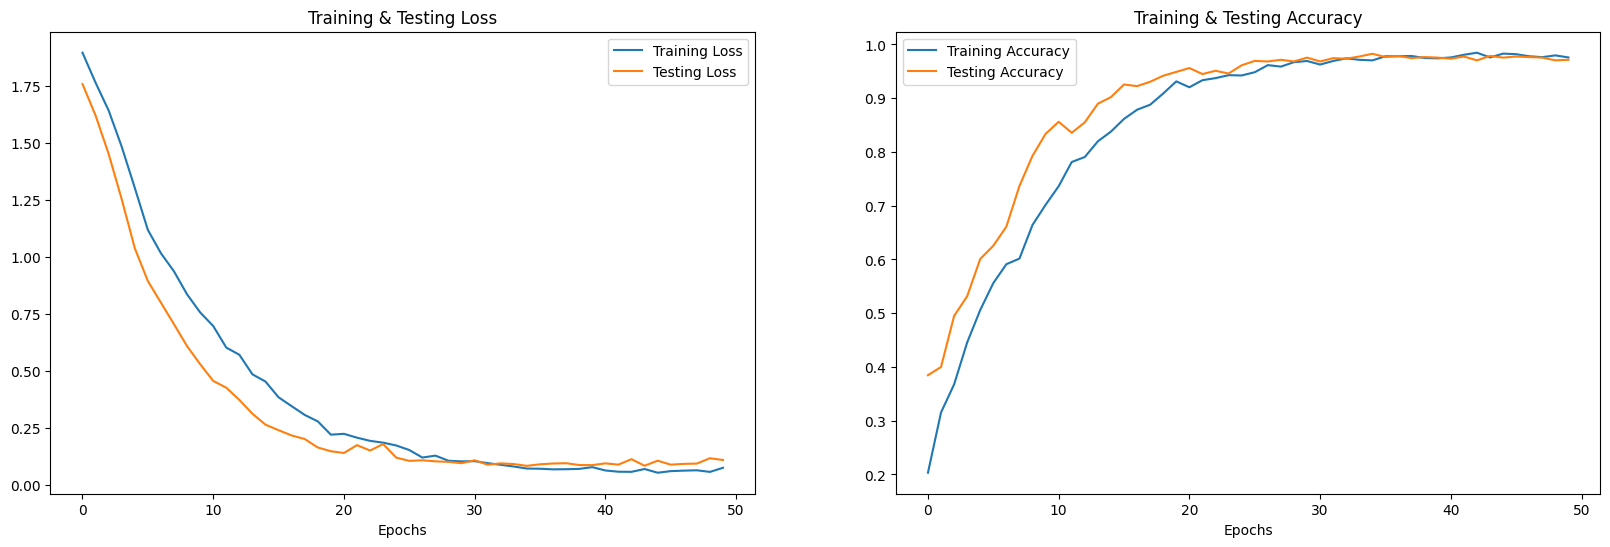

In [32]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [33]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

31/31 [==============================] - 2s 43ms/step


In [34]:
x_test.shape

(980, 40, 1)

In [35]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.to_csv('predictions.csv')
print("predictions are saved to ./predictions.csv")

predictions are saved to ./predictions.csv


## Experimental Results and Analysis

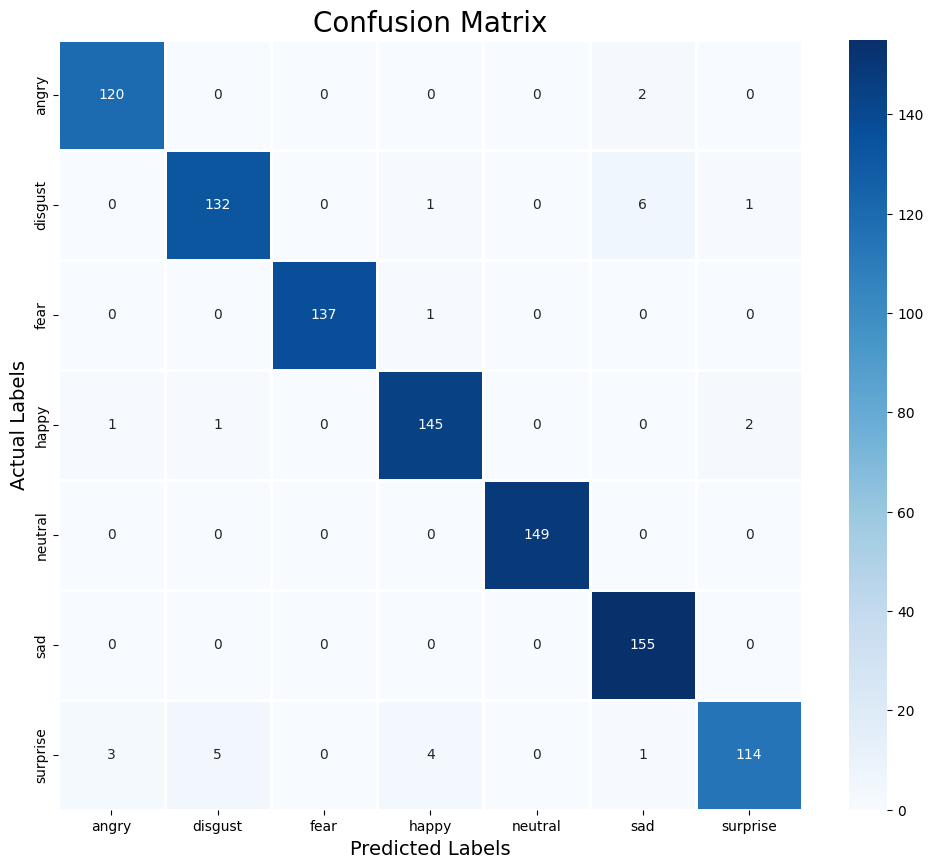

In [36]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.97      0.98      0.98       122
     disgust       0.96      0.94      0.95       140
        fear       1.00      0.99      1.00       138
       happy       0.96      0.97      0.97       149
     neutral       1.00      1.00      1.00       149
         sad       0.95      1.00      0.97       155
    surprise       0.97      0.90      0.93       127

    accuracy                           0.97       980
   macro avg       0.97      0.97      0.97       980
weighted avg       0.97      0.97      0.97       980



## Save the Model

In [38]:
from tensorflow import keras

model.save('mymodel.h5')

my_model = keras.models.load_model('./mymodel.h5')

## Live Audio Emotion Prediction

In [39]:
#RECORDED USING MICROPHONE:
import pyaudio
import wave

CHUNK = 1024
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2
RATE = 44100 #sample rate
RECORD_SECONDS = 3
WAVE_OUTPUT_FILENAME = "recorded-audio.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")
frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


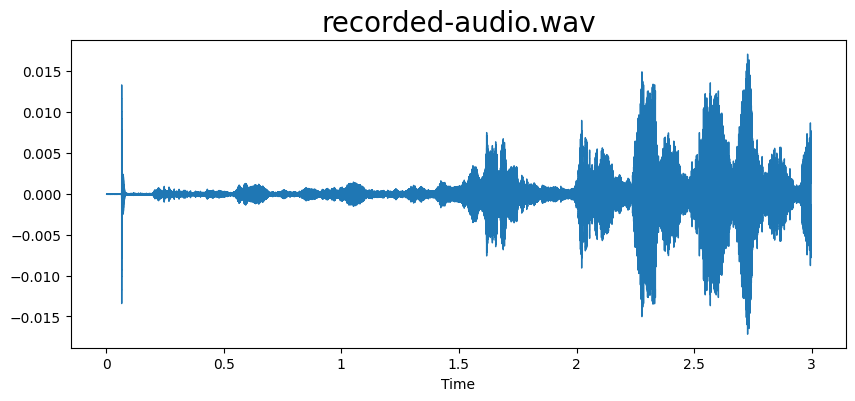

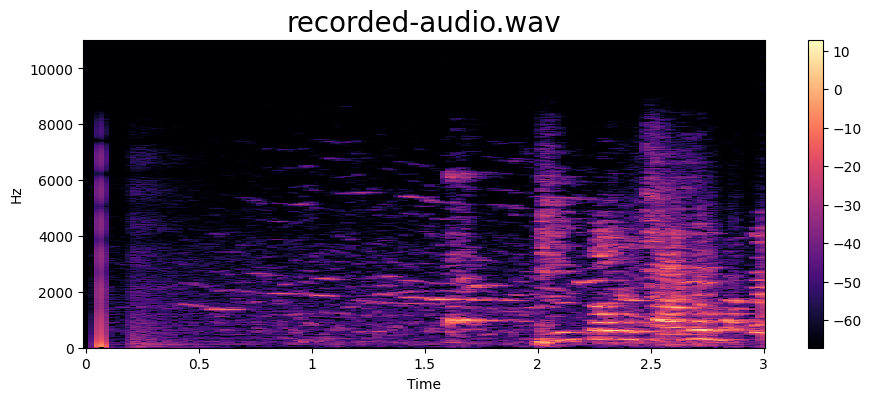

In [40]:
data, sampling_rate = librosa.load('./recorded-audio.wav')
waveplot(data, sampling_rate, 'recorded-audio.wav')
spectogram(data, sampling_rate, 'recorded-audio.wav')
Audio('./recorded-audio.wav')

In [41]:
ans = []
new_feature = extract_mfcc("./recorded-audio.wav")
ans.append(new_feature)
ans = np.array(ans)

In [42]:
audio_pred = my_model.predict(ans)
audio_pred = encoder.inverse_transform(audio_pred)
audio_pred

1/1 [==============================] - 1s 721ms/step


array([['disgust']], dtype=object)